In [1]:
import datetime
import os
import numpy as np 
import pandas as pd
import glob


from qerr_utils import *
pd.options.mode.chained_assignment = None  # default='warn'

In [35]:
# Get a list of files in a directory
def getFiles(dirName):
    # os.chdir()
    allFiles = np.asarray(glob.glob(f"{dirName}/*.txt"))
    # Sort files - Note that this will not work if you have a different enumeration setup (e.g. you don't have an underscore)
    allFiles = sorted(allFiles, key = lambda x: float(x[x.rindex('_') + 1:x.index('.')]))
    return allFiles[:]

# Read data from data files
def getData(aFile):
    times = []
    deltas = []
    with open(aFile, 'r') as f:
        f.readline()
        for aLine in f:
            holder = aLine.split('\t')
            aDate = datetime.datetime.strptime(holder[0], '%m/%d/%Y %H:%M:%S.%f:')
            if float(holder[1].strip()) < 1e5:
                times.append(aDate)
                deltas.append(float(holder[1].strip()))
    return times, deltas

def scope_to_df(dataDir):
    allFiles = getFiles(dataDir)

    allTimes = []
    allDeltas = []
    
    # Get a list of files
    for aFile in allFiles:
        holderTimes, holderDeltas = getData(aFile)
        allTimes = np.concatenate((allTimes, holderTimes))
        allDeltas = np.concatenate((allDeltas, holderDeltas))
    
    df = pd.DataFrame(
        {
            'unix_timestamp': allTimes,
            'delta (ns)': allDeltas
        }
    )
    return df


def qerr_vs_time(df, scope_name):
    df['seconds elapsed'] = (df['towMS (ms)'] - df['towMS (ms)'].min()) / 10**3
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    sns.lineplot(df, x='seconds elapsed', y='qErr (ps)', linewidth=1.2, ax=ax)
    sns.regplot(df, x='seconds elapsed', y='qErr (ps)', scatter=True, ax=ax, order=15, scatter_kws={'s':2})
    
    ax.set_title(f'Q-Errors (ps) vs Elapsed Time (s) [{scope_name}]');
    ax.set_xlabel('Elapsed Time (s)')
    ax.set_ylabel('Q-Errors (ps)')

def qerr_hist(df):
    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.histplot(df, x='qErr (ps)', stat='density', ax=ax)
    ax.set_title('Distribution of Q-Errors (ps)')
    ax.set_xlabel('Q-Errors (ps)');

def load_merged_df(merged_fpath):
    df = load_data(merged_fpath)
    df['unix_timestamp'] = df['pkt_unix_timestamp_TIM-TP'].astype('datetime64[ns]')
    df['qErr (ns)'] = df['qErr (ps)'] * 1e-3
    return df

In [36]:
fpath_s3 = '/Users/nico/panoseti/gnss-pdft/qerr/data/start_2024-06-28T13:32:07.396892.device_ttyS3/data-type_MERGED.start_2024-06-28T13:32:07.396892'
fpath_s5 = '/Users/nico/panoseti/gnss-pdft/qerr/data/start_2024-06-28T13:32:32.459060.device_ttyS5/data-type_MERGED.start_2024-06-28T13:32:32.459060'

s3 = load_merged_df(fpath_s3)
s5 = load_merged_df(fpath_s5)
d = scope_to_df('/Users/nico/panoseti/gnss-pdft/scope/ScopeData/survey-in-end-20240628')
# qerr_vs_time(s3, 's3'),qerr_vs_time(s5, 's5');

In [215]:
# Get timestamps
s3_tst = s3['unix_timestamp']
s5_tst = s5['unix_timestamp']
d_tst = d['unix_timestamp']

# Find latest start time among d, s3, and s5 dataframes.
d_aligned_idx = np.searchsorted(d_tst, min(s3_tst))
d_aligned_idx = max(d_aligned_idx, np.searchsorted(d_tst, min(s5_tst)))
latest_start_time = d_tst[d_aligned_idx]

# Find indices in s3 and s5 closest to latest start time.
s3_start_idx = np.searchsorted(s3_tst, latest_start_time)
s5_start_idx = np.searchsorted(s5_tst, latest_start_time)

d_offset = 2

print(s3['unix_timestamp'].iloc[s3_start_idx])
print(s5['unix_timestamp'].iloc[s5_start_idx])
print(d['unix_timestamp'].iloc[d_aligned_idx + d_offset])

# Trim data frames so that the earliest record is the latest starting time.
s3_aligned = s3[s3_start_idx:]
s5_aligned = s5[s5_start_idx:]
d_aligned = d[d_aligned_idx + d_offset:]

# Add elapsed time to dataframes for plotting
s3_aligned['Elapsed Time (s)'] = (s3_aligned['unix_timestamp'] - s3_aligned['unix_timestamp'].min()).apply(datetime.timedelta.total_seconds).round(0)
s5_aligned['Elapsed Time (s)'] = (s5_aligned['unix_timestamp'] - s5_aligned['unix_timestamp'].min()).apply(datetime.timedelta.total_seconds).round(0)
d_aligned['Elapsed Time (s)'] = (d_aligned['unix_timestamp'] - d_aligned['unix_timestamp'].min()).apply(datetime.timedelta.total_seconds).round(0)

# Trim data frames to same length.
len_limit = min(len(d_aligned), len(s3_aligned), len(s5_aligned))
s3_aligned = s3_aligned[:len_limit]
s5_aligned = s5_aligned[:len_limit]
d_aligned = d_aligned[:len_limit]

# Use elapsed time for index
s3_aligned = s3_aligned.set_index('Elapsed Time (s)')
s5_aligned = s5_aligned.set_index('Elapsed Time (s)')
d_aligned = d_aligned.set_index('Elapsed Time (s)')





# s3_aligned['Elapsed Time (s)'] = (s3_aligned['unix_timestamp'] - s3_aligned['unix_timestamp'].min()).apply(datetime.timedelta.total_seconds).round(0)
# s5_aligned['Elapsed Time (s)'] = (s5_aligned['unix_timestamp'] - s5_aligned['unix_timestamp'].min()).apply(datetime.timedelta.total_seconds).round(0)
# d_aligned['Elapsed Time (s)'] = (d_aligned['unix_timestamp'] - d_aligned['unix_timestamp'].min()).apply(datetime.timedelta.total_seconds).round(0)

"""
Dan's email:
corrected_deltaT =   (Tpps1 - qErr1) - (Tpps0 - qErr0)   (1) 
                 =   (Tpps1 - Tpps0) - (qErr1 - qErr0)   (2) 
                 =   deltaT - (qErr1 - qErr0)            (3)
"""


d_aligned['delta & qerrs (ns) [s3 - s5]'] = d_aligned['delta (ns)'] - (s3_aligned['qErr (ns)'] - s5_aligned['qErr (ns)'])
d_aligned['delta & qerrs (ns) [s5 - s3]'] = d_aligned['delta (ns)'] - (s5_aligned['qErr (ns)'] - s3_aligned['qErr (ns)'])

# reset_index
s3_aligned = s3_aligned.reset_index()
s5_aligned = s5_aligned.reset_index()
d_aligned = d_aligned.reset_index()

2024-06-28 13:32:34.359186
2024-06-28 13:32:34.361470
2024-06-28 13:32:35.567148


In [210]:
d_diffs = d_aligned['Elapsed Time (s)'].diff()
two_idxs = d_diffs[d_diffs == 2].index.values
two_idxs_times = d_aligned.iloc[two_idxs]
two_idxs_times

Elapsed Time (s)             unix_timestamp  delta (ns)  \
22                23.0 2024-06-28 13:32:58.070482       8.531   
137              139.0 2024-06-28 13:34:54.072863      12.270   
241              244.0 2024-06-28 13:36:39.070029      14.507   
384              388.0 2024-06-28 13:39:03.078327      13.629   
532              537.0 2024-06-28 13:41:32.067714      11.600   
676              682.0 2024-06-28 13:43:57.077858      18.743   
824              831.0 2024-06-28 13:46:26.067635      13.779   
914              922.0 2024-06-28 13:47:57.075128      14.406   
1045            1054.0 2024-06-28 13:50:09.075017      10.863   
1152            1162.0 2024-06-28 13:51:57.072815      14.081   
1283            1294.0 2024-06-28 13:54:09.070274      13.249   
1419            1431.0 2024-06-28 13:56:26.071440      16.049   
1518            1531.0 2024-06-28 13:58:06.070467      15.950   
1623            1637.0 2024-06-28 13:59:52.075167      13.545   
1731            1746.0 2024-06-28 14:01:41.071284      17.324   
1815            1831.0 2024-06-28 14:03:06.074668      13.181   
1917            1934.0 2024-06-28 14:04:49.069134       9.321   
1988            2006.0 2024-06-28 14:06:01.067397       6.098   
2111            2130.0 2024-06-28 14:08:05.080106      12.222   
2233            2253.0 2024-06-28 14:10:08.078021       9.870   
2352            2373.0 2024-06-28 14:12:08.077807      13.626   
2468            2490.0 2024-06-28 14:14:05.072454      17.100   
2575            2598.0 2024-06-28 14:15:53.070782      10.380   
2704            2728.0 2024-06-28 14:18:03.073165      19.687   
2836            2861.0 2024-06-28 14:20:16.075439      14.091   
2954            2980.0 2024-06-28 14:22:15.078236      12.862   
3079            3106.0 2024-06-28 14:24:21.078431      14.860   
3186            3214.0 2024-06-28 14:26:09.072662      18.077   
3301            3330.0 2024-06-28 14:28:05.076420      12.889   

      delta & qerrs (ns) [s3 - s5]  delta & qerrs (ns) [s5 - s3]  
22                          12.757                         4.305  
137                         14.448                        10.092  
241                         16.902                        12.112  
384                         10.223                        17.035  
532                         16.603                         6.597  
676                         18.377                        19.109  
824                         15.903                        11.655  
914                         12.301                        16.511  
1045                        14.460                         7.266  
1152                        19.946                         8.216  
1283                        15.625                        10.873  
1419                        11.157                        20.941  
1518                        21.817                        10.083  
1623                        17.126                         9.964  
1731                        11.993                        22.655  
1815                        12.391                        13.971  
1917                        12.155                         6.487  
1988                         9.608                         2.588  
2111                        14.825                         9.619  
2233                        10.096                         9.644  
2352                        10.794                        16.458  
2468                        13.538                        20.662  
2575                        12.092                         8.668  
2704                        24.209                        15.165  
2836                        16.759                        11.423  
2954                        13.817                        11.907  
3079                        14.676                        15.044  
3186                        19.012                        17.142  
3301                        10.601                        15.177

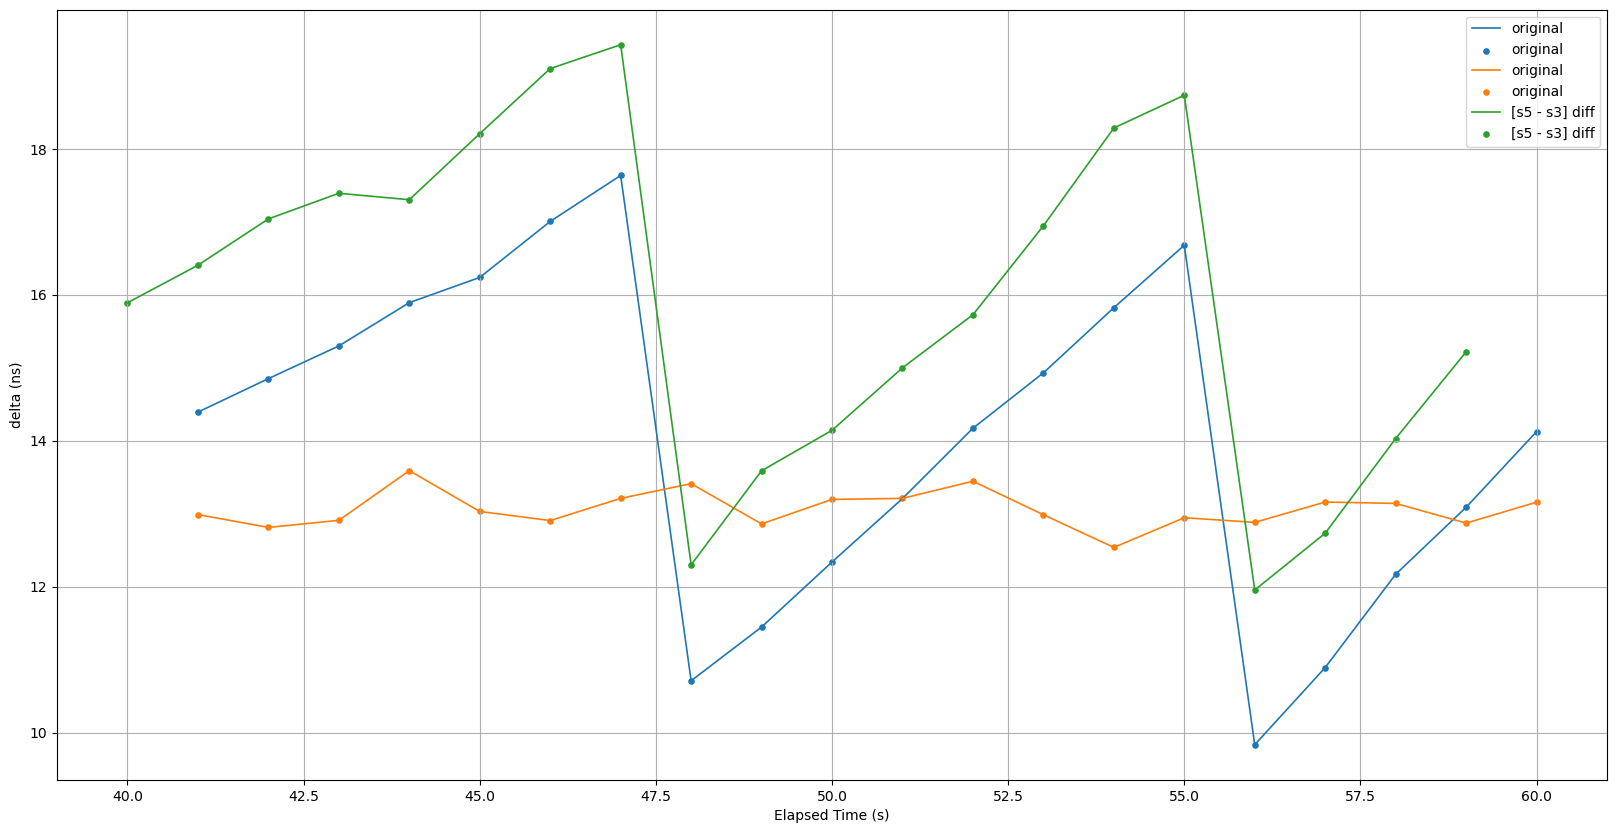

In [211]:
plt.figure(figsize=(20,10))
d_aligned_slice = d_aligned[40:60]
sliced = s5_aligned['qErr (ns)'] - s3_aligned['qErr (ns)'][40:60]
sns.lineplot(d_aligned_slice, x='Elapsed Time (s)', y='delta (ns)', linewidth=1.2,  label='original')
sns.scatterplot(d_aligned_slice, x='Elapsed Time (s)', y='delta (ns)', linewidth=1.2,  label='original')

sns.lineplot(d_aligned_slice, x='Elapsed Time (s)', y='delta & qerrs (ns) [s3 - s5]', linewidth=1.2,  label='original')
sns.scatterplot(d_aligned_slice, x='Elapsed Time (s)', y='delta & qerrs (ns) [s3 - s5]', linewidth=1.2,  label='original')
# sns.lineplot(d_aligned_slice, x='Elapsed Time (s)', y='delta & qerrs (ns) [s5 - s3]', linewidth=1.2, label='[s5 - s3]')
sns.lineplot(sliced+15, linewidth=1.2, label='[s5 - s3] diff')
sns.scatterplot(sliced+15, linewidth=1.2, label='[s5 - s3] diff')
plt.grid()
plt.show()

<Figure size 7680x5760 with 0 Axes>

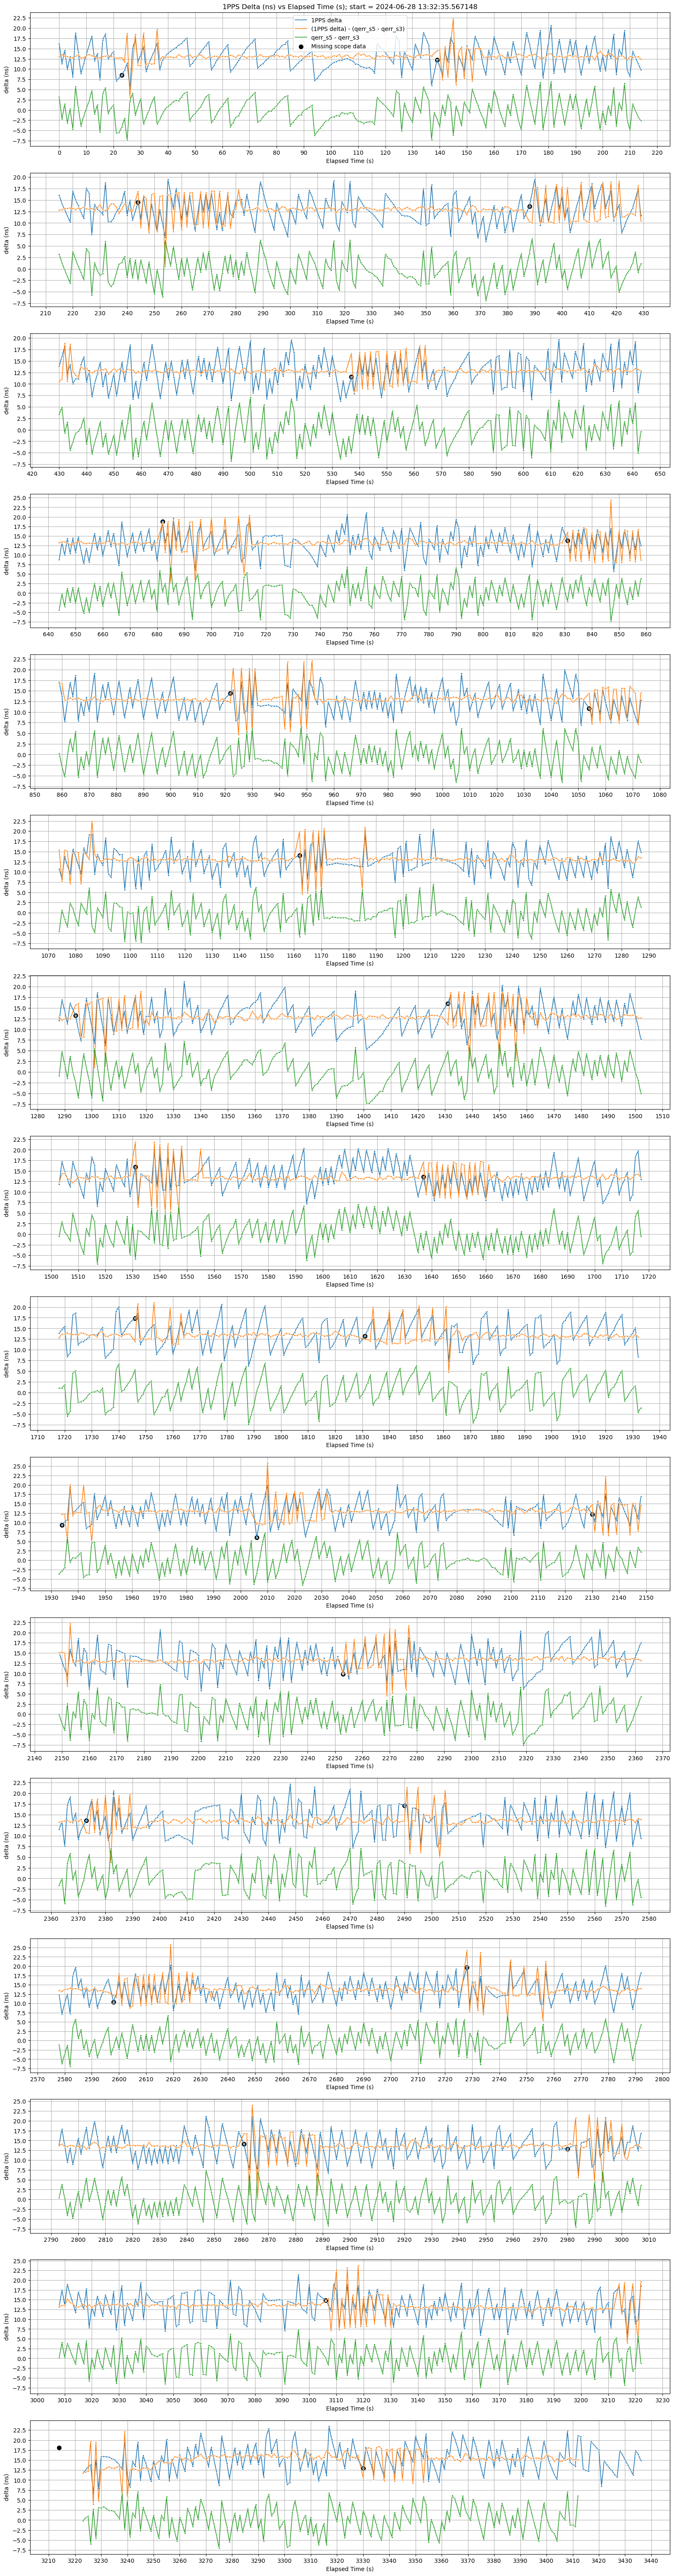

In [217]:
# Original deltas
plt.figure(dpi=1200) 
nslices = 16
slice_size = (len(d_aligned) // nslices)
f, axs = plt.subplots(nslices, 1, figsize=(20, 80))

axs[0].set_title(f'1PPS Delta (ns) vs Elapsed Time (s); start = {d_aligned["unix_timestamp"][0]}');
for i in range(nslices):
    # Compute offsets due to bad scope points.
    offset = sum(two_idxs < slice_size * i)
    pad = sum((slice_size * i <= two_idxs) & (two_idxs <= slice_size * (i + 1)))

    ax = axs[i]
    ax.grid(True)
    ax.set_xticks(np.arange(0, slice_size * (i + 1) + ((pad + offset) // 10 + 2) * 10, 10))
    ax.set_yticks(np.arange(-7.5, 27.5, 2.5))
    
    d_aligned_slice = d_aligned[slice_size * i: slice_size * (i + 1)]
    qerr = (s5_aligned['qErr (ns)'] - s3_aligned['qErr (ns)'])[slice_size * i + offset: slice_size * (i + 1) + pad + offset]
    two_idxs_in_slize = two_idxs_times[((slice_size * i) < two_idxs_times['Elapsed Time (s)']) & (two_idxs_times['Elapsed Time (s)'] <= slice_size * (i + 1))]

    sns.lineplot(d_aligned_slice, x='Elapsed Time (s)', y='delta (ns)', linewidth=1.2, ax=ax, marker=".", label='1PPS delta')
    sns.lineplot(d_aligned_slice, x='Elapsed Time (s)', y='delta & qerrs (ns) [s5 - s3]', linewidth=1.2, ax=axs[i], marker=".", label='(1PPS delta) - (qerr_s5 - qerr_s3)')
    sns.lineplot(qerr, linewidth=1.2, ax=ax, label='qerr_s5 - qerr_s3', marker=".")

    ax.scatter(two_idxs_in_slize['Elapsed Time (s)'], two_idxs_in_slize['delta (ns)'], s=50, c='k', marker='o', label='Missing scope data')

    ax.legend()
    # sns.lineplot(d_aligned_slice, x='Elapsed Time (s)', y='delta & qerrs (ns) [s3 - s5]', linewidth=1.2, ax=axs[i], label='[s3 - s5]')
    if i > 0:
        ax.get_legend().remove();


count    3413.000000
mean       13.294771
std         3.219484
min         5.233000
25%        11.005000
50%        13.249000
75%        15.550000
max        23.431000
Name: delta (ns), dtype: float64 


count    3384.000000
mean       13.353566
std         2.245100
min         0.154000
25%        12.845000
50%        13.216500
75%        13.704000
max        25.756000
Name: delta & qerrs (ns) [s5 - s3], dtype: float64 




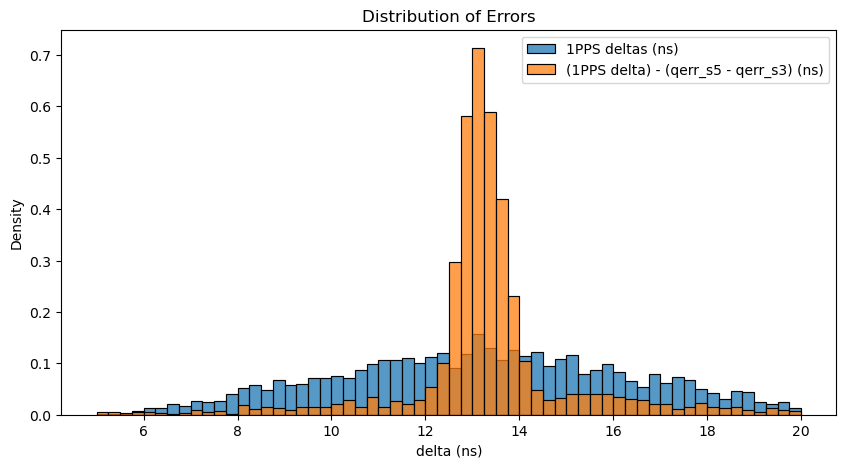

In [219]:
plt.figure(figsize=(10,5))
cols = ['delta (ns)', 'delta & qerrs (ns) [s5 - s3]']

sns.histplot(d_aligned, x='delta (ns)', stat='density', binrange=[5, 20], binwidth=0.25, label='1PPS deltas (ns)');
sns.histplot(d_aligned, x='delta & qerrs (ns) [s5 - s3]', stat='density', binrange=[5, 20], binwidth=0.25, label='(1PPS delta) - (qerr_s5 - qerr_s3) (ns)');
# print(f'Summary stats for {key}\n')
print(d_aligned['delta (ns)'].describe(), '\n\n')
print(d_aligned['delta & qerrs (ns) [s5 - s3]'].describe(), '\n\n')

plt.title('Distribution of Errors')
plt.legend()

count    3413.000000
mean       13.294771
std         3.219484
min         5.233000
25%        11.005000
50%        13.249000
75%        15.550000
max        23.431000
Name: delta (ns), dtype: float64 


count    3384.000000
mean       13.353566
std         2.245100
min         0.154000
25%        12.845000
50%        13.216500
75%        13.704000
max        25.756000
Name: delta & qerrs (ns) [s5 - s3], dtype: float64 




Text(0.5, 1.0, 'Distribution of (1PPS delta) - (qerr_s5 - qerr_s3) (ns)')

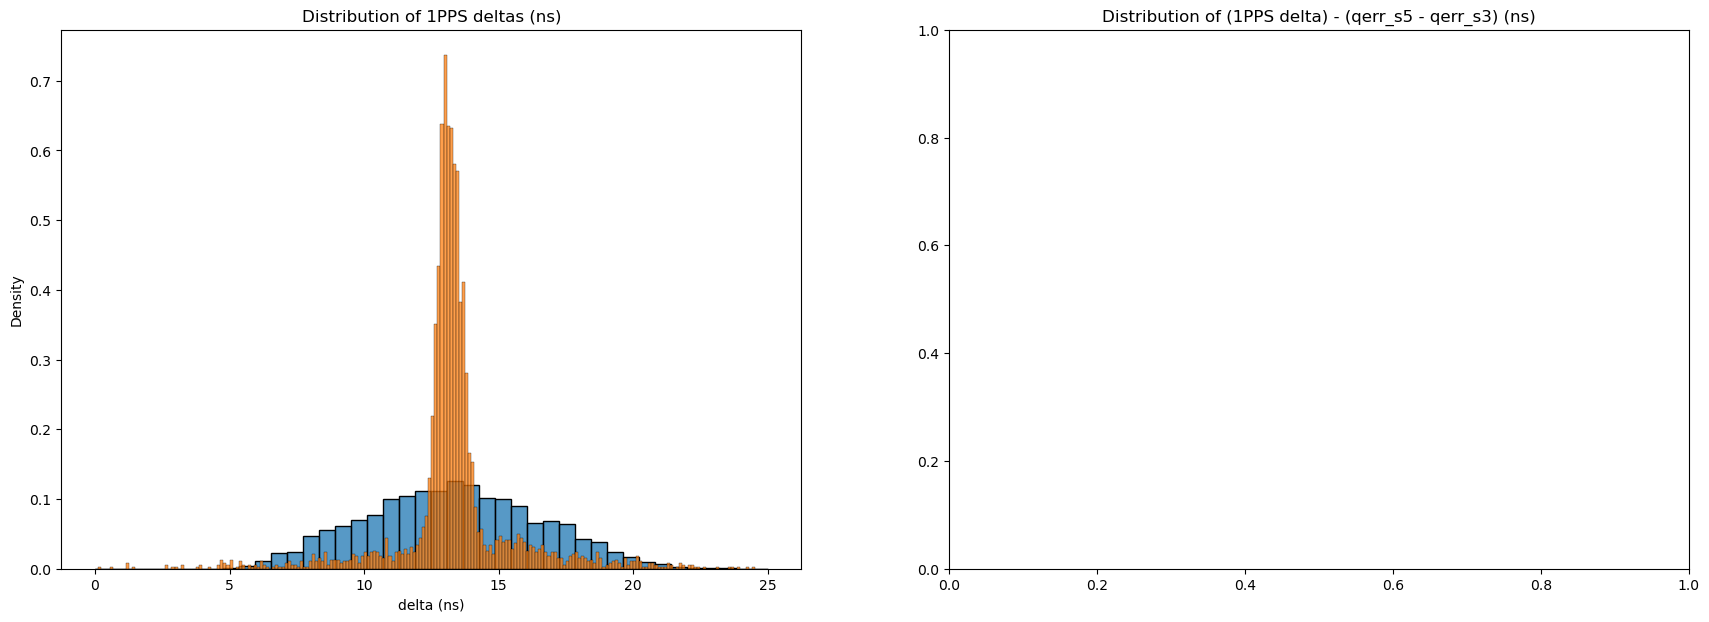

In [104]:
f, axs = plt.subplots(1, 2, figsize=(21, 7))


cols = ['delta (ns)', 'delta & qerrs (ns) [s5 - s3]']
for i in range(len(cols)):
    key = cols[i]
    sns.histplot(d_aligned, x=key, ax=axs[0], stat='density', binrange=[0, 25]);
    # print(f'Summary stats for {key}\n')
    print(d_aligned[key].describe(), '\n\n')

axs[0].set_title('Distribution of 1PPS deltas (ns)')
axs[1].set_title('Distribution of (1PPS delta) - (qerr_s5 - qerr_s3) (ns)')

In [13]:
abs(s5_aligned['unix_timestamp'].diff()).describe()

count                         3412
mean     0 days 00:00:00.999990244
std      0 days 00:00:00.006445849
min         0 days 00:00:00.963595
25%      0 days 00:00:00.996610500
50%         0 days 00:00:01.000084
75%      0 days 00:00:01.003311250
max         0 days 00:00:01.043586
Name: unix_timestamp, dtype: object

In [14]:
abs(s3_aligned['unix_timestamp'].diff()).describe()

count                         3412
mean     0 days 00:00:00.999990249
std      0 days 00:00:00.005908023
min         0 days 00:00:00.935531
25%         0 days 00:00:00.996702
50%         0 days 00:00:01.000331
75%      0 days 00:00:01.003004250
max         0 days 00:00:01.072812
Name: unix_timestamp, dtype: object

In [15]:
abs(d_aligned['unix_timestamp'].diff()).describe()

count                         3412
mean     0 days 00:00:01.008634595
std      0 days 00:00:00.006511235
min         0 days 00:00:01.001740
25%      0 days 00:00:01.003590750
50%      0 days 00:00:01.008442500
75%      0 days 00:00:01.010844500
max         0 days 00:00:01.106630
Name: unix_timestamp, dtype: object

In [16]:
abs(s5_aligned['unix_timestamp'] - s3_aligned['unix_timestamp']).describe()

count                         3413
mean     0 days 00:00:00.003491471
std      0 days 00:00:00.003770861
min                0 days 00:00:00
25%         0 days 00:00:00.001207
50%         0 days 00:00:00.002432
75%         0 days 00:00:00.004354
max         0 days 00:00:00.034072
Name: unix_timestamp, dtype: object

In [17]:
abs(d_aligned['unix_timestamp'] - s3_aligned['unix_timestamp']).describe()

count                         3413
mean     0 days 00:00:15.889274807
std      0 days 00:00:08.578493718
min         0 days 00:00:01.207962
25%         0 days 00:00:07.942035
50%         0 days 00:00:15.498178
75%         0 days 00:00:23.616110
max         0 days 00:00:30.702471
Name: unix_timestamp, dtype: object

<Axes: ylabel='unix_timestamp'>

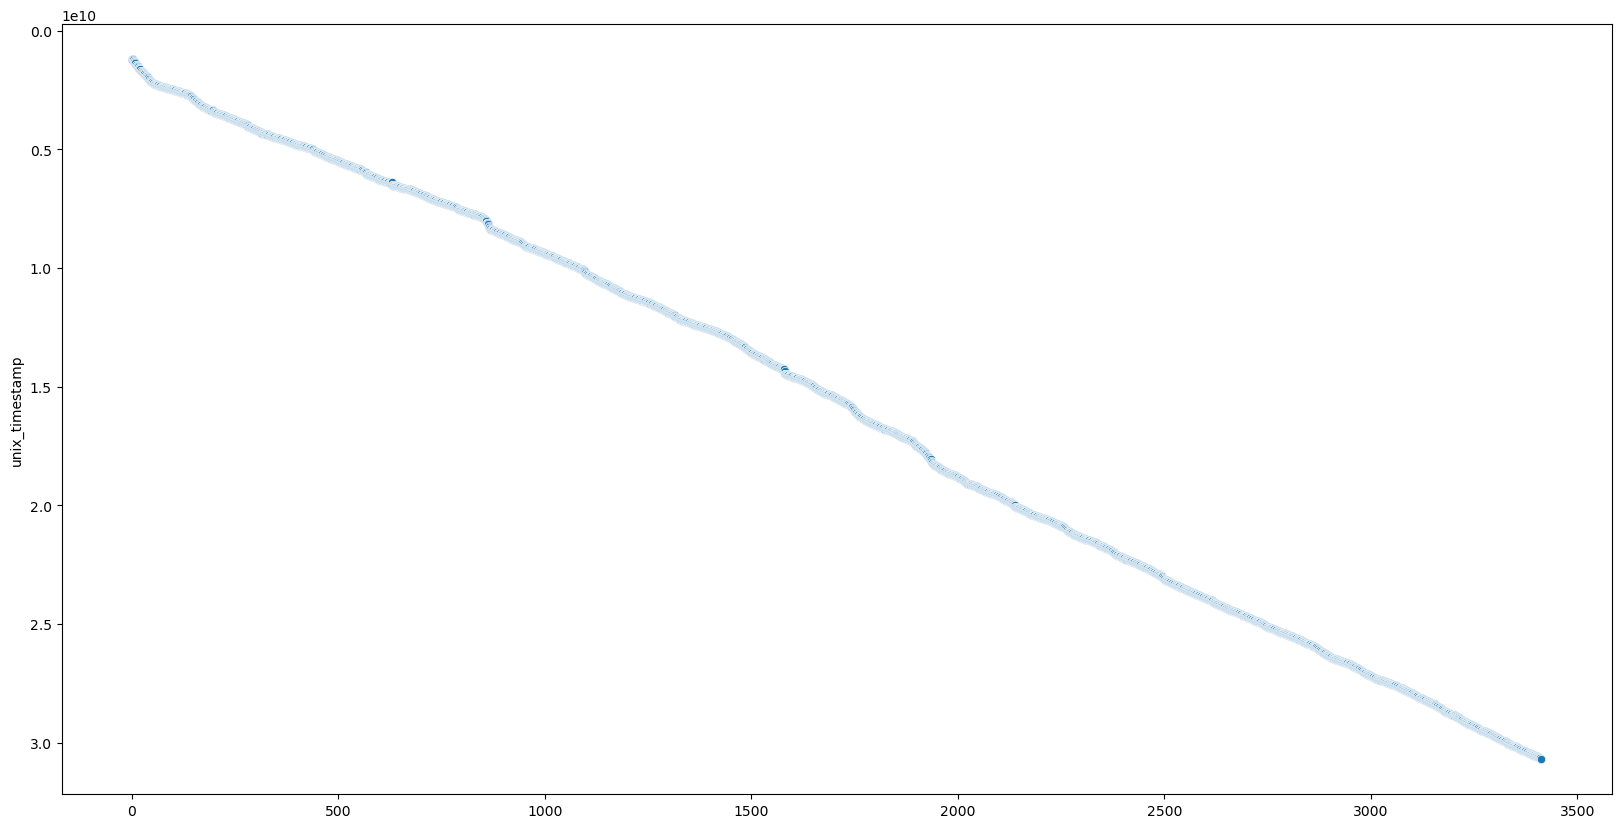

In [18]:
plt.figure(figsize=(20,10))
sns.scatterplot(d_aligned['unix_timestamp'] - s3_aligned['unix_timestamp'])

In [19]:
d_aligned['unix_timestamp'][0].timestamp()

1719581555.567148

In [20]:
aligned['unix_timestamp'].diff().dropna().describe()

NameError: name 'aligned' is not defined

In [ ]:
d_aligned['unix_timestamp'].diff().idxmax()

In [ ]:
d_aligned.iloc[1581-10: 1581 + 10]

In [ ]:
s3_aligned['unix_timestamp']